In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from einops import rearrange, repeat
from scipy import stats

from models.mlp import CFGResNet, ResNet
from models.airfoil_MLP import EDM_CFG, VP_1D, ProbabilityFlowODE, Airfoil1D_Dataset, edm_sampler, StackedRandomGenerator
from models.airfoil_surrogate import Airfoil_surrogate_Dataset

In [2]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [3]:
seed_everything(0)

with open('pickle_files/unique_y_coords.pkl', 'rb') as f:
    unique_y_coords = pickle.load(f)

with open('pickle_files/y_coord_mapping.pkl', 'rb') as f:
    y_coord_mapping = pickle.load(f)

with open('pickle_files/index_to_name_mapping.pkl', 'rb') as f:
    index_to_name_mapping = pickle.load(f)

with open('pickle_files/processed_cond_data.pkl', 'rb') as f:
    processed_cond_data = pickle.load(f)

with open('pickle_files/minmax_scaler.pkl', 'rb') as f:
    minmax_scaler = pickle.load(f)

with open('pickle_files/pca.pkl', 'rb') as f:
    pca = pickle.load(f)

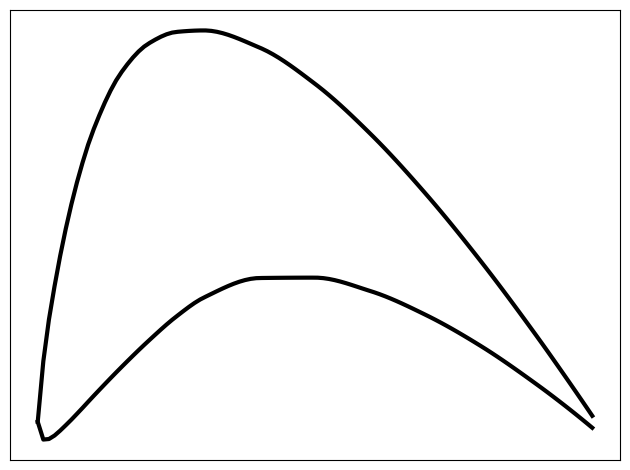

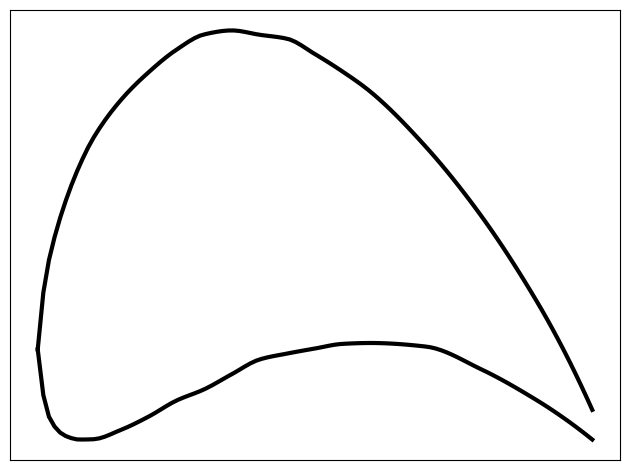

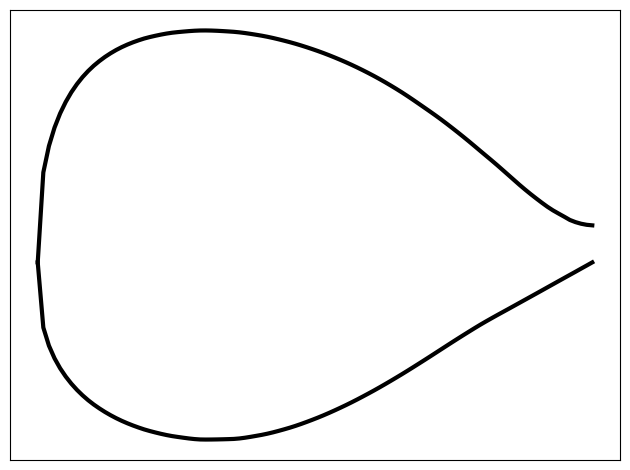

In [4]:
def plot_airfoil(sample, name=''):
    plt.rcdefaults()
    y_coord = sample.reshape(2,100)
    plt.plot(y_coord[0,:], c='k', linewidth=3)
    plt.plot(y_coord[1,:], c='k', linewidth=3)
    plt.xticks([])  # Turn off x-axis ticks
    plt.yticks([])  # Turn off y-axis ticks
    plt.tight_layout()
    #plt.savefig('tmp/'+name+'.svg', dpi=600)
    plt.show()

plot_airfoil(unique_y_coords[0], 'tmp1')
plot_airfoil(unique_y_coords[1], 'tmp2')
plot_airfoil(unique_y_coords[2], 'tmp3')

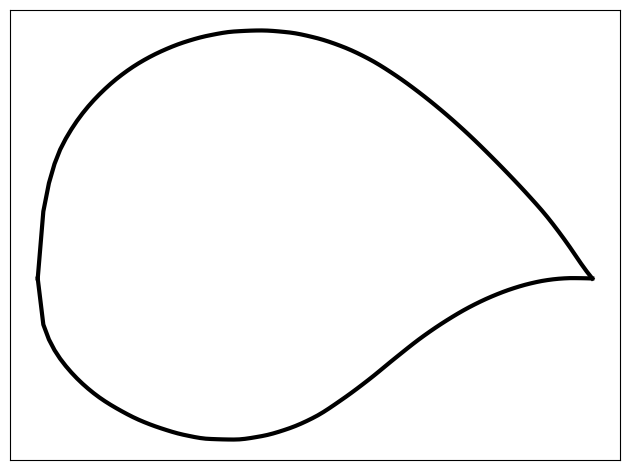

In [5]:
baseline_idx = y_coord_mapping['rae5212-il - RAE(NPL) 5212 AIRFOIL']
plot_airfoil(unique_y_coords[baseline_idx], 'baseline')

sigma_current 80.0
noisy_latent [[140.76902458  32.61786005  78.33068115 179.19866138 149.42853592
  -78.1703758 ]]


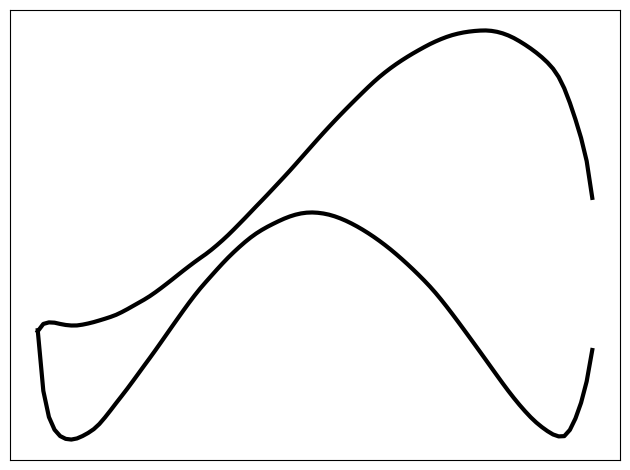

In [6]:
def plot_noisy_image_at_step(latent, num_steps, current_step, sigma_min=0.002, sigma_max=80, rho=7, pca=pca):
    # Assuming the latent is already provided by the user as an input.
    # Calculate noise schedule for the current step
    np.random.seed(0)
    step_index = torch.tensor([current_step], dtype=torch.float64)
    sigma_current = (sigma_max ** (1 / rho) + step_index / (num_steps - 1) * (
                     sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho

    # Function to apply noise
    def apply_noise(image, sigma):
        noisy_image = image + np.random.randn(*image.shape) * sigma
        return noisy_image

    # Apply noise to the latent image
    noisy_latent = apply_noise(latent, sigma_current.item())
    print('sigma_current', sigma_current.item())
    print('noisy_latent', noisy_latent)

    plot_airfoil(pca.inverse_transform(noisy_latent), 'noisy_latent')

plot_noisy_image_at_step(pca.transform(np.array(unique_y_coords[0]).reshape(1,-1)), num_steps=6, current_step=0)


In [7]:
seed_everything(0)

beta_min = 1e-4 # for SDE noise [VP]
beta_max = 10 # for SDE noise [VP]
num_components = 6
method = 'EDM' # 'CFG' or 'EDM'


batch_size = 2048
unique_y_coords = pca.transform(np.asarray(unique_y_coords).reshape(-1, 200))
dataset = Airfoil1D_Dataset(unique_y_coords, y_coord_mapping, processed_cond_data, index_to_name_mapping)
surrogate_dataset = Airfoil_surrogate_Dataset(unique_y_coords, y_coord_mapping, processed_cond_data, index_to_name_mapping)
generator = torch.Generator().manual_seed(0)
surrogate_train_set, surrogate_val_set = torch.utils.data.random_split(surrogate_dataset, [0.8,0.2], generator=generator)
surrogate_train_loader = torch.utils.data.DataLoader(
    surrogate_train_set, batch_size=batch_size, shuffle=False
)
surrogate_val_loader = torch.utils.data.DataLoader(
    surrogate_val_set, batch_size=batch_size, shuffle=False
)

print('Using method: ', method)
if method == 'CFG':
    model = CFGResNet(num_components, num_components, cond_size=4, model_dim=128,
                    dim_mult=[1,2,2], dim_mult_emb=4, num_blocks=2,
                    dropout=0, emb_type="sinusoidal", dim_mult_time=1, 
                    dim_mult_cond=1, cond_drop_prob=0, adaptive_scale=True, skip_scale=1.0, affine=True)
elif method == 'EDM':
    model = EDM_CFG(num_components, num_components, cond_size=4, model_dim=128,
                dim_mult=[1,2,2], dim_mult_emb=4, num_blocks=2,
                dropout=0, emb_type="sinusoidal", dim_mult_time=1, 
                dim_mult_cond=1, cond_drop_prob=0, adaptive_scale=True, skip_scale=1.0, affine=True)
else:
    raise NotImplementedError

surrogate_model = ResNet(in_dim = num_components+2, out_dim=2, model_dim=128, dim_mult=[1,1,1], num_blocks=1, 
                   dropout=0., adaptive_scale=True, skip_scale=1.0, affine=False)

vp = VP_1D(beta_min, beta_max)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model.load_state_dict(torch.load('mdl_weight/reduced/betamax_10_b512_500epoch.pth'))
model.load_state_dict(torch.load('mdl_weight/edm.pth'))
surrogate_model.load_state_dict(torch.load('mdl_weight/surrogate_model.pth'))
model = model.to(device)
surrogate_model = surrogate_model.to(device)

Using method:  EDM


In [8]:
surrogate_dataset.__len__()

767559

/tmp/ipykernel_1074880/3027167311.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, rotation=45, fontsize=8)
/tmp/ipykernel_1074880/3027167311.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, rotation=45, fontsize=8)
/tmp/ipykernel_1074880/3027167311.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, rotation=45, fontsize=8)
/tmp/ipykernel_1074880/3027167311.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, rotation=45, fontsize=8)
/tmp/ipykernel_1074880/3027167311.py:52: UserWarning: set_ticklabels() should only be used with a fixed numb

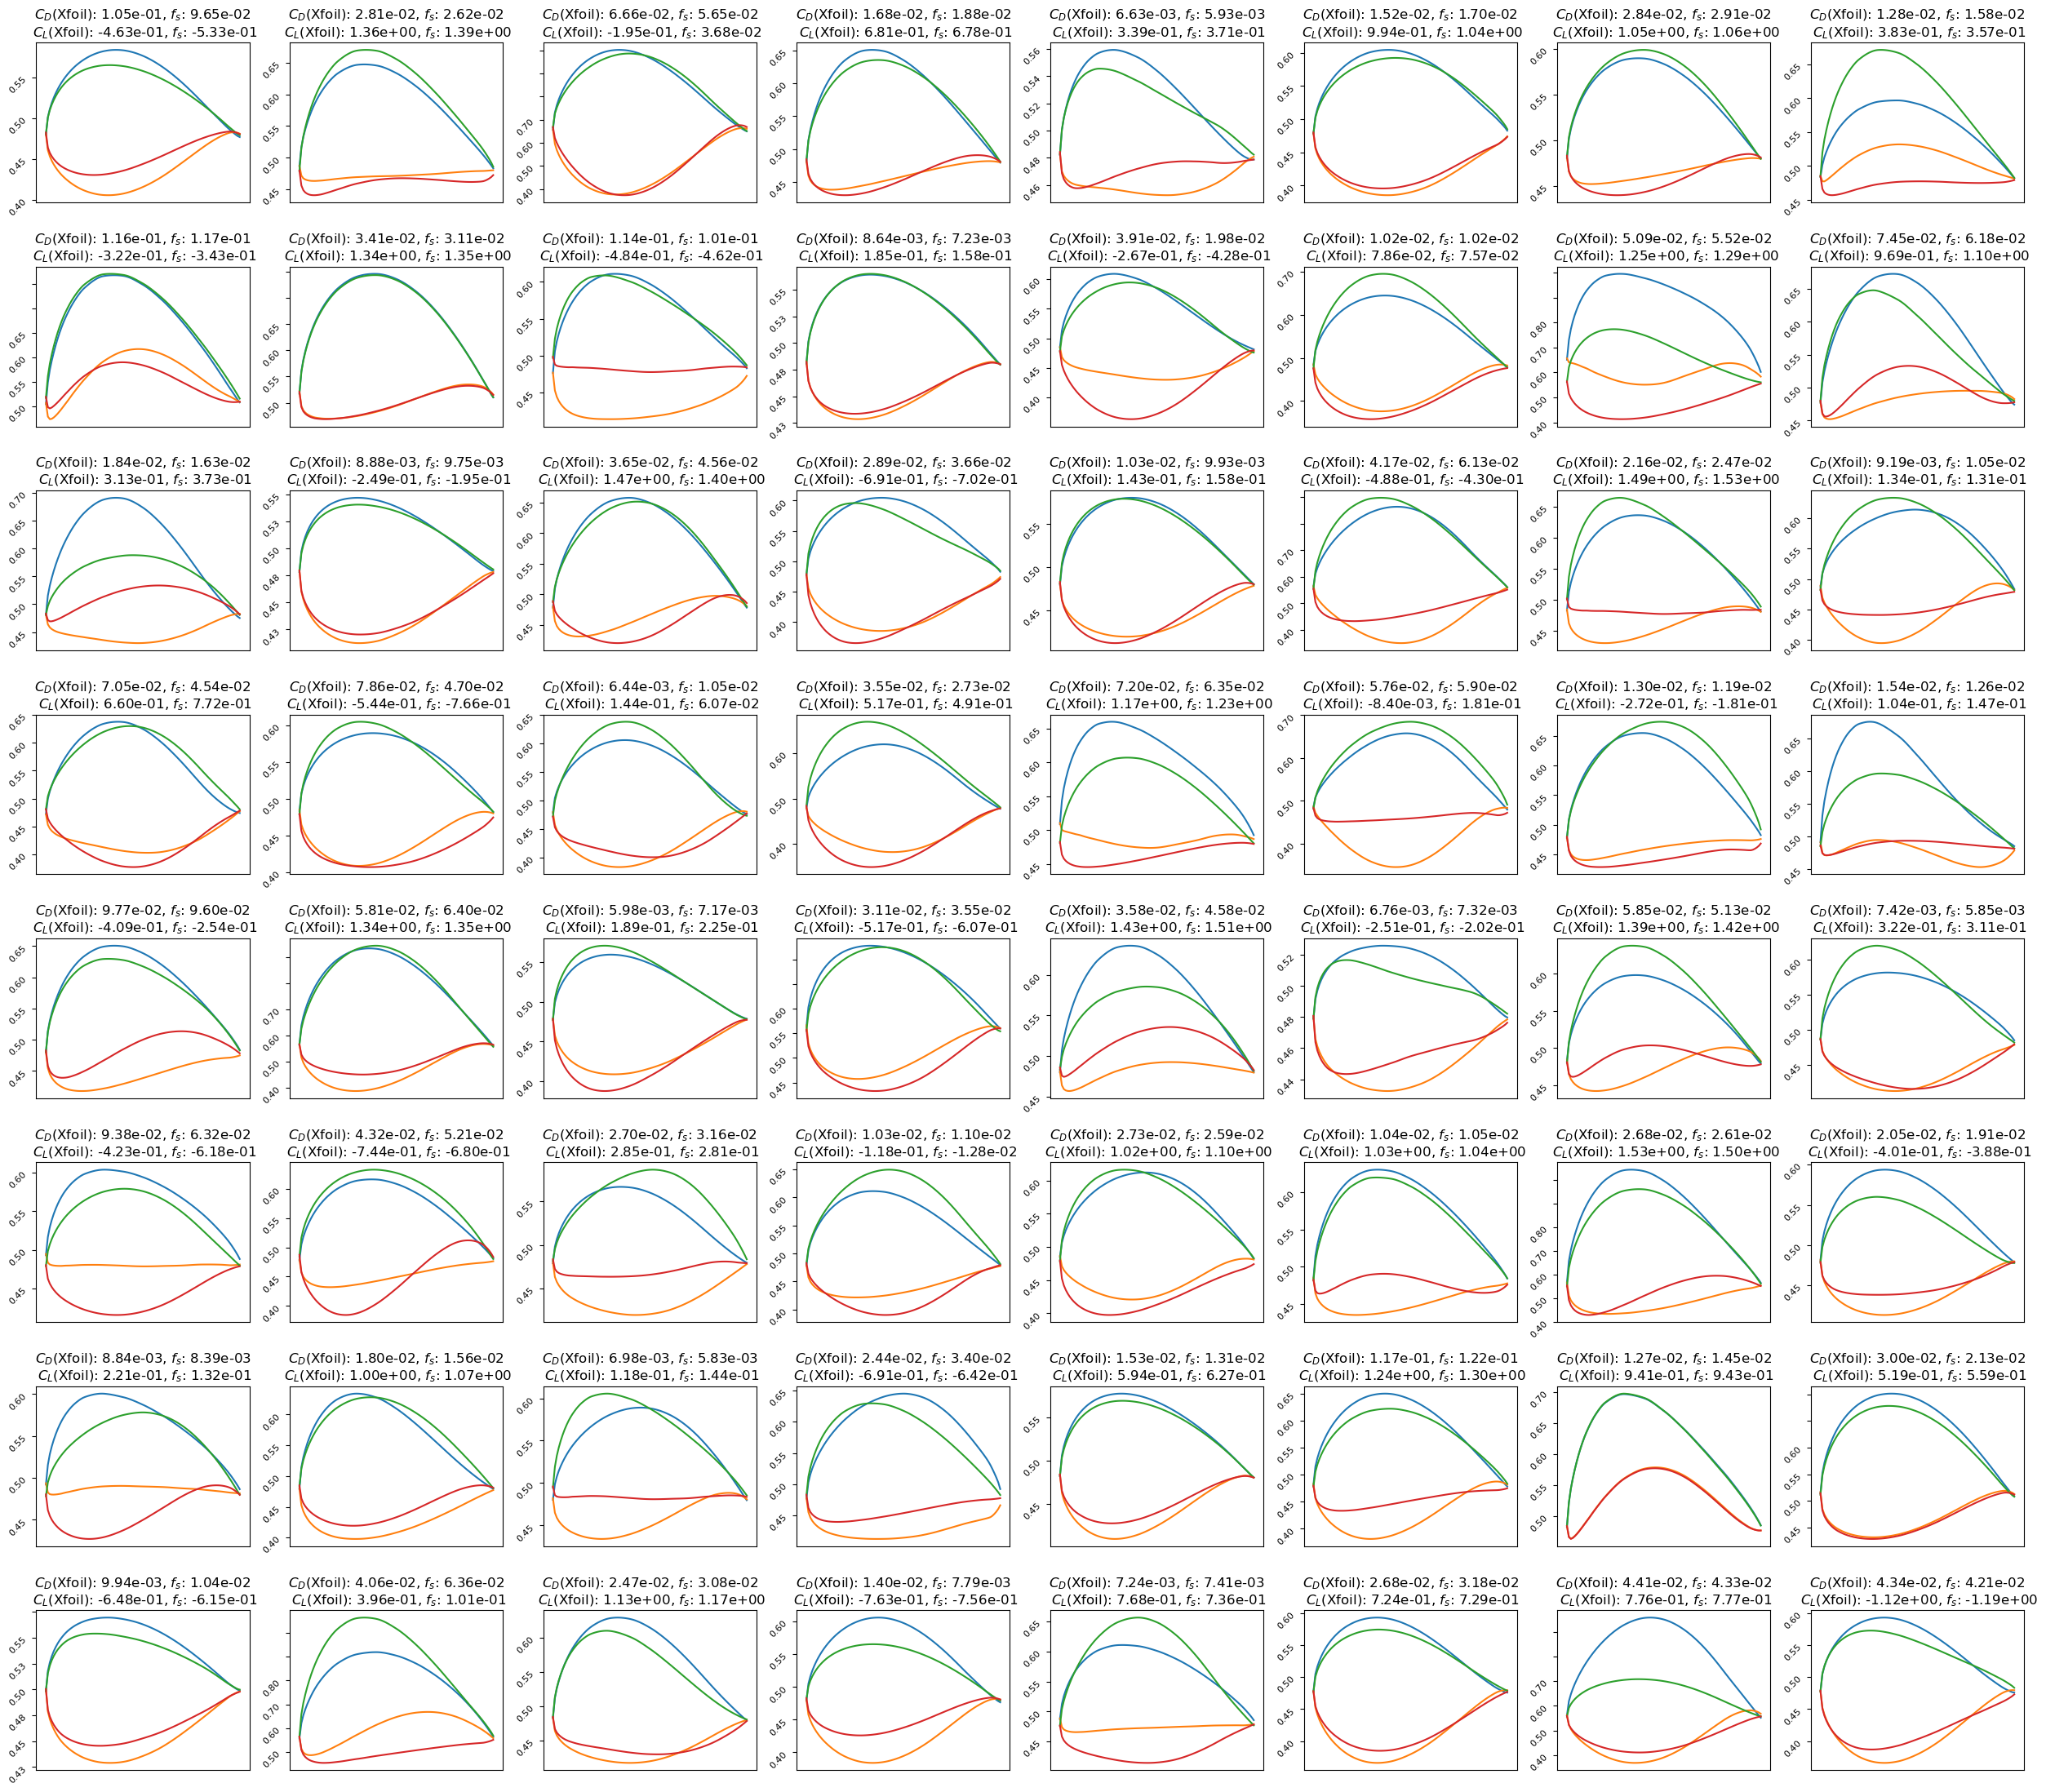

In [9]:
def get_plot(model, surrogate_model, vp, sample_size, minmax_scaler, pca, save_name, dataset=None, orig_tuple: tuple = None, method='EDM'):
    plt.rcdefaults()
    model.eval()
    if dataset is not None:
        indices = np.random.choice(len(dataset), sample_size, replace=False)
    else:
        indices = np.random.choice(len(orig_tuple[0]), sample_size, replace=False)
    #em_sampler = EulerMaruyama(1000, 1e-5, 0, sample_size)
    if dataset is not None:
        # Get test_cond for each index in indices
        test_cond = [dataset[i][1] for i in indices]
        test_cond = torch.stack(test_cond).to(device)
        #test_cond[:,0] = 0

        if method == 'CFG':
            pf_sampler = ProbabilityFlowODE(1000, 1e-5)
            samples, _ = pf_sampler(model, vp, (sample_size, 6), device, c=test_cond, return_intermediates=False)
        elif method == 'EDM':
            rnd = StackedRandomGenerator(device, range(sample_size))
            latents = rnd.randn([sample_size, model.in_dim], device=device)
            with torch.no_grad():
                samples, _ = edm_sampler(model, latents=latents, class_labels=test_cond, randn_like=rnd.randn_like, deterministic=True) 
            samples = samples.float()
            
    else:
        samples = orig_tuple[0]
        test_cond = orig_tuple[1]
        input_orig_shape = orig_tuple[2]

    fig, axs = plt.subplots(int(np.sqrt(sample_size)), int(np.sqrt(sample_size)), figsize=(25, 22), sharex=True)
    for i, idx in enumerate(indices):
        # Get the test_cond and sample
        orig_shape = dataset[idx][0].cpu().numpy() if dataset is not None else input_orig_shape
        tmp_pred = surrogate_model(torch.cat((samples[i], test_cond[i, 2:])))
        cd_pred = minmax_scaler['Cd'].inverse_transform(tmp_pred[0].cpu().detach().numpy().reshape(1,-1))
        cl_pred = minmax_scaler['Cl'].inverse_transform(tmp_pred[1].cpu().detach().numpy().reshape(1,-1))
        tmp_orig_cd = minmax_scaler['Cd'].inverse_transform(test_cond[i][0].cpu().detach().numpy().reshape(1,-1))
        tmp_orig_cl = minmax_scaler['Cl'].inverse_transform(test_cond[i][1].cpu().detach().numpy().reshape(1,-1))
        sample = samples[i].cpu().numpy()
        orig_shape = pca.inverse_transform(orig_shape).reshape(2,100)
        sample = pca.inverse_transform(sample).reshape(2,100)
        # Determine the subplot
        ax = axs[i // int(np.sqrt(sample_size)), i % int(np.sqrt(sample_size))]

        # Plot the data
        ax.plot(orig_shape[0,:])
        ax.plot(orig_shape[1,:])
        ax.plot(sample[0,:])
        ax.plot(sample[1,:])
        ax.xaxis.set_visible(False)
        labels = [f'{label:.2f}' for label in ax.get_yticks()]
        ax.set_yticklabels(labels, rotation=45, fontsize=8)
        ax.set_title('$C_D$(Xfoil): {:0.2e}, $f_s$: {:0.2e}\n $C_L$(Xfoil): {:0.2e}, $f_s$: {:0.2e}'.format(tmp_orig_cd[0][0], cd_pred[0][0], tmp_orig_cl[0][0], cl_pred[0][0]), fontsize=12)

    # Display the plot
    plt.tight_layout()
    #plt.savefig('figs/'+save_name+'.eps', dpi=600)
    plt.show()

get_plot(model, surrogate_model, vp, 64, minmax_scaler, pca, 'airfoil_gen', dataset, method='EDM')

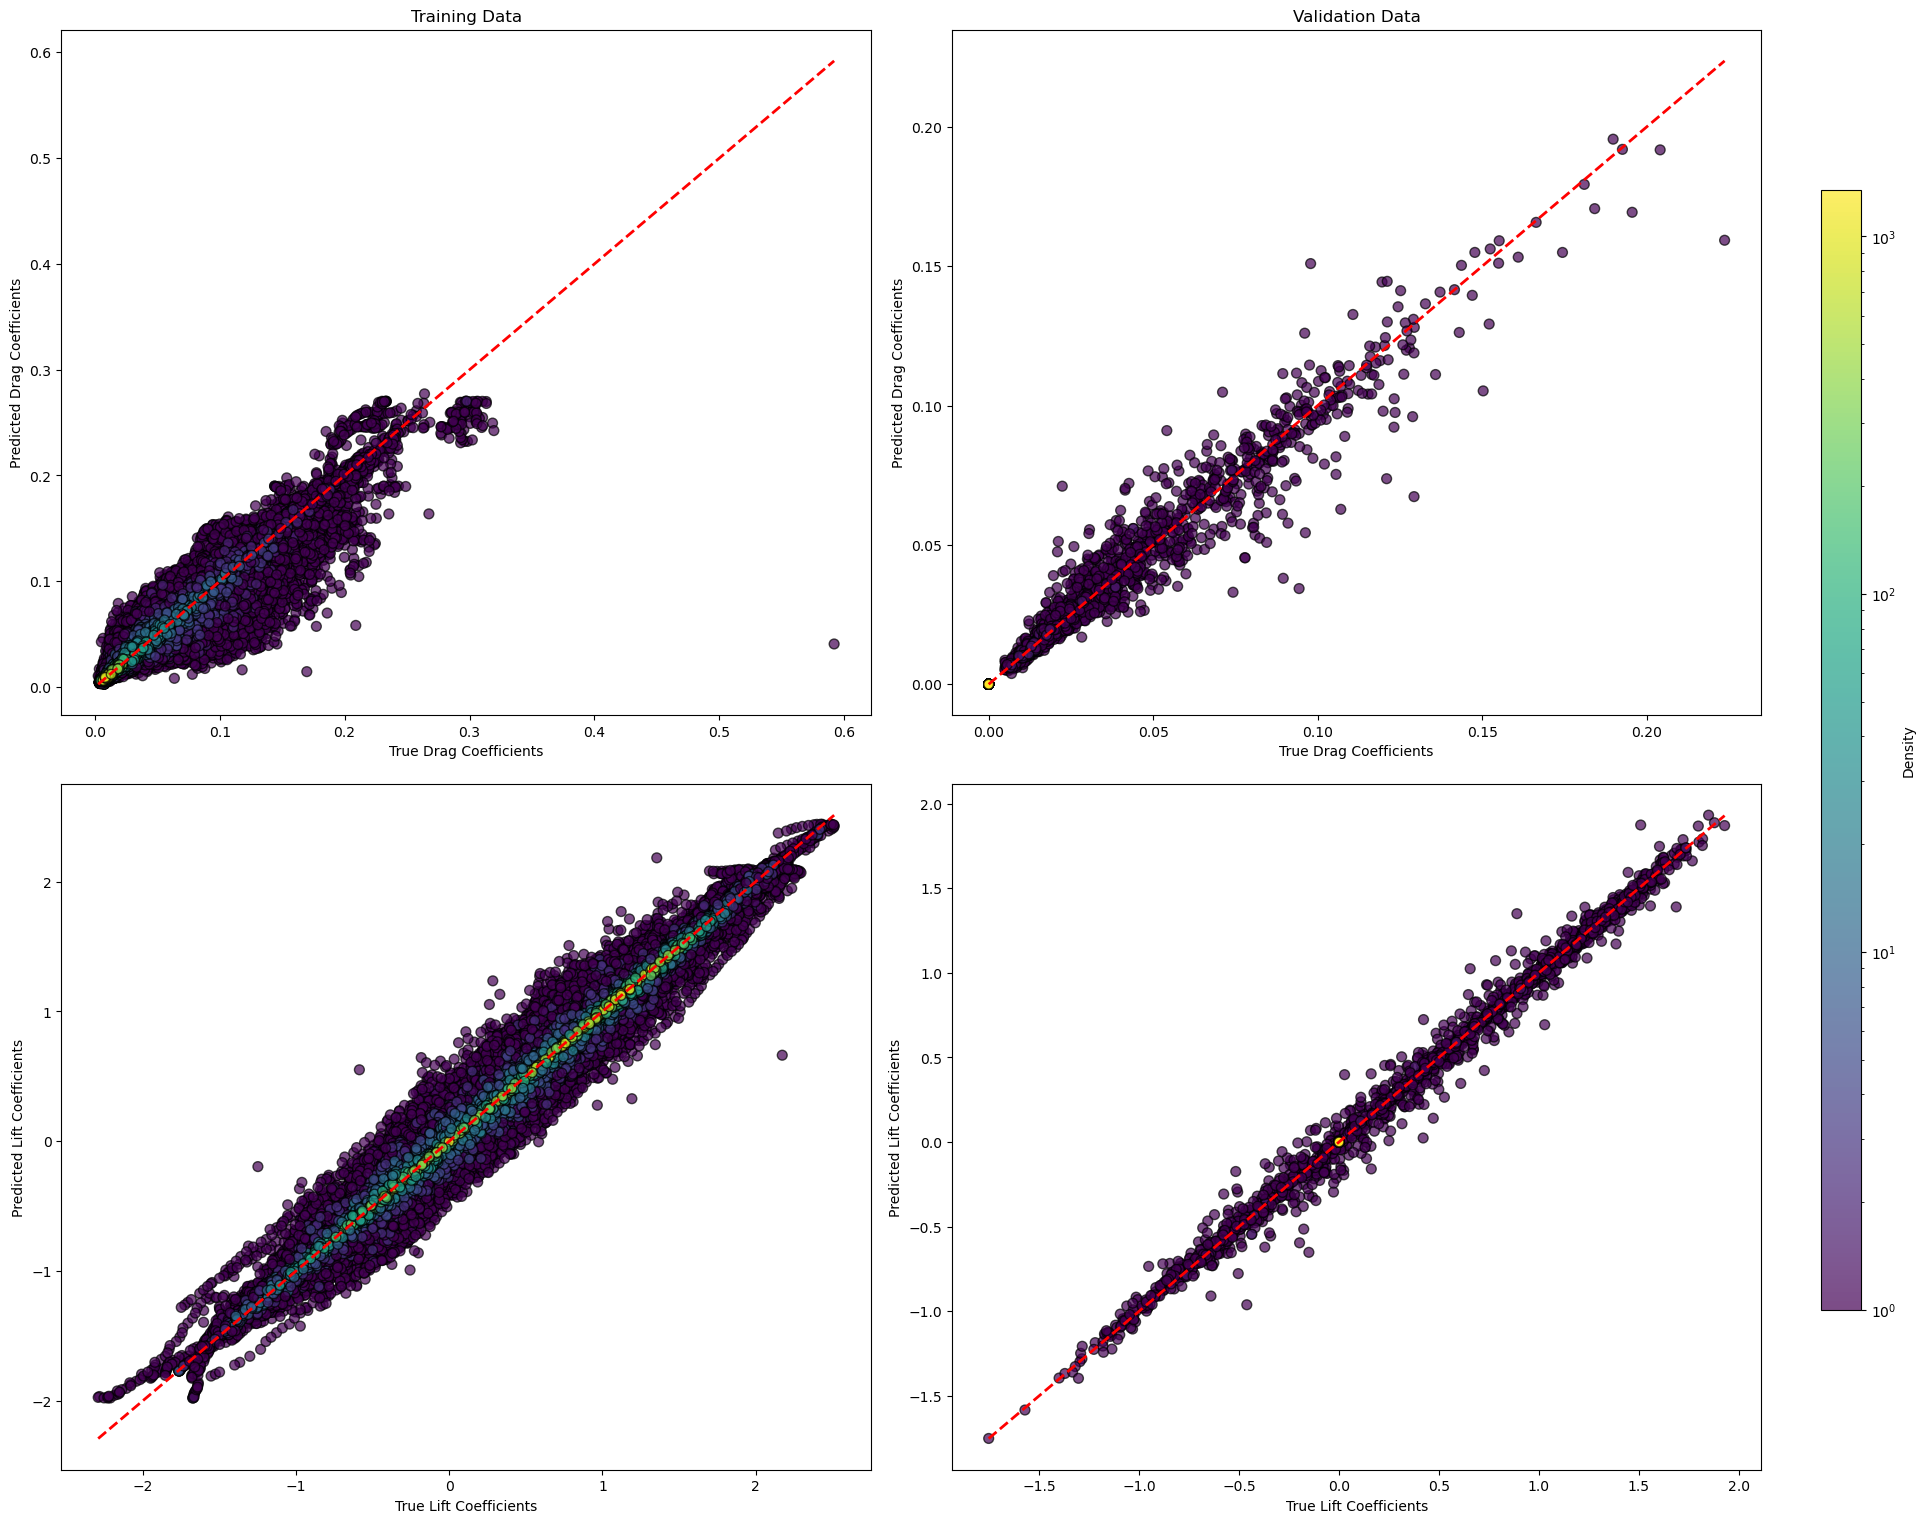

CD Train RMSE:  0.007546535001334254 CD Val RMSE:  0.0008735486727076798
CL Train RMSE:  0.06477188984775005 CL Val RMSE:  0.007769391403718465


In [10]:
#'''
#plt.rc("font", family="serif", size="20")
#plt.rc("axes", labelsize="x-large")
#plt.rc("figure", figsize=(10, 10))

def create_scatter_plot(ax, true_data, pred_data, title, xlabel, ylabel):
    hist, xedges, yedges = np.histogram2d(true_data, pred_data, bins=1000)
    xidx = np.clip(np.digitize(true_data, xedges) - 1, 0, hist.shape[0] - 1)
    yidx = np.clip(np.digitize(pred_data, yedges) - 1, 0, hist.shape[1] - 1)
    colors = hist[xidx, yidx]
    scatter = ax.scatter(true_data, pred_data, c=colors, cmap='viridis', s=50, alpha=0.7, edgecolor='k', norm=LogNorm())
    ax.plot([min(true_data), max(true_data)], [min(true_data), max(true_data)], linestyle='--', color='red', linewidth=2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title)
    return scatter

# Assuming Y_pred and Y_test have been computed
with torch.no_grad():
    train_cd_true = np.zeros(len(surrogate_train_set))
    train_cd_pred = np.zeros(len(surrogate_train_set))
    val_cd_true = np.zeros(len(surrogate_val_set))
    val_cd_pred = np.zeros(len(surrogate_val_set))
    train_cl_true = np.zeros(len(surrogate_train_set))
    train_cl_pred = np.zeros(len(surrogate_train_set))
    val_cl_true = np.zeros(len(surrogate_val_set))
    val_cl_pred = np.zeros(len(surrogate_val_set))
    current_index = 0
    for i, (x, y) in enumerate(surrogate_train_loader):
        x = x.to(device)
        y = y.to(device)
        num_batch = x.shape[0]
        train_cd_true[current_index:current_index+num_batch] = minmax_scaler['Cd'].inverse_transform(y[:,0].cpu().numpy().reshape(-1,1)).flatten()
        train_cd_pred[current_index:current_index+num_batch] = minmax_scaler['Cd'].inverse_transform(surrogate_model(x)[:,0].flatten().cpu().numpy().reshape(-1,1)).flatten()
        train_cl_true[current_index:current_index+num_batch] = minmax_scaler['Cl'].inverse_transform(y[:,1].cpu().numpy().reshape(-1,1)).flatten()
        train_cl_pred[current_index:current_index+num_batch] = minmax_scaler['Cl'].inverse_transform(surrogate_model(x)[:,1].flatten().cpu().numpy().reshape(-1,1)).flatten()
        current_index += num_batch
    current_index = 0
    for i, (x, y) in enumerate(surrogate_val_loader):
        x = x.to(device)
        y = y.to(device)
        num_batch = x.shape[0]
        val_cd_true[current_index:current_index+num_batch] = minmax_scaler['Cd'].inverse_transform(y[:,0].cpu().numpy().reshape(-1,1)).flatten()
        val_cd_pred[current_index:current_index+num_batch] = minmax_scaler['Cd'].inverse_transform(surrogate_model(x)[:,0].flatten().cpu().numpy().reshape(-1,1)).flatten()
        val_cl_true[current_index:current_index+num_batch] = minmax_scaler['Cl'].inverse_transform(y[:,1].cpu().numpy().reshape(-1,1)).flatten()
        val_cl_pred[current_index:current_index+num_batch] = minmax_scaler['Cl'].inverse_transform(surrogate_model(x)[:,1].flatten().cpu().numpy().reshape(-1,1)).flatten()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Creating scatter plots
scatter_train_cd = create_scatter_plot(axes[0, 0], train_cd_true, train_cd_pred, 'Training Data', 'True Drag Coefficients', 'Predicted Drag Coefficients')
scatter_val_cd = create_scatter_plot(axes[0, 1], val_cd_true, val_cd_pred, 'Validation Data', 'True Drag Coefficients', 'Predicted Drag Coefficients')
scatter_train_cl = create_scatter_plot(axes[1, 0], train_cl_true, train_cl_pred, None, 'True Lift Coefficients', 'Predicted Lift Coefficients')
scatter_val_cl = create_scatter_plot(axes[1, 1], val_cl_true, val_cl_pred, None, 'True Lift Coefficients', 'Predicted Lift Coefficients')

# Manual adjustment of the layout
fig.subplots_adjust(left=0.05, right=0.9, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

# Adding colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # x, y, width, height
cbar = fig.colorbar(scatter_train_cd, cax=cbar_ax)
cbar.set_label('Density')

# Show the plot
#plt.savefig('figs/surrogate.png', dpi=400)
plt.show()
print('CD Train RMSE: ', np.sqrt(np.mean((train_cd_true - train_cd_pred)**2)), 'CD Val RMSE: ', np.sqrt(np.mean((val_cd_true - val_cd_pred)**2)))
print('CL Train RMSE: ', np.sqrt(np.mean((train_cl_true - train_cl_pred)**2)), 'CL Val RMSE: ', np.sqrt(np.mean((val_cl_true - val_cl_pred)**2)))
#'''

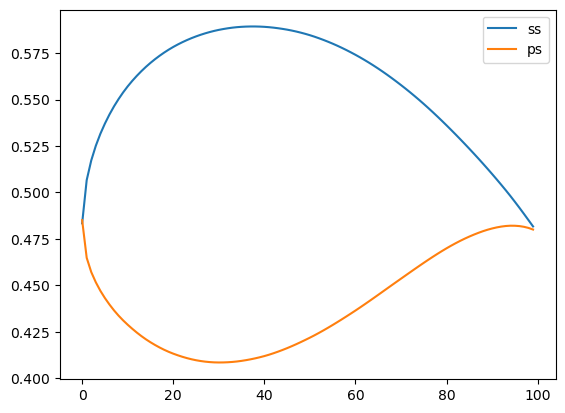

In [11]:
def plot_airfoil(sample, name=''):
    plt.rcdefaults()
    y_coord = pca.inverse_transform(sample).reshape(2,100)
    plt.plot(y_coord[0,:], label='ss')
    plt.plot(y_coord[1,:], label='ps')
    plt.legend()
    #plt.savefig('figs/'+name+'.eps', dpi=600)
    plt.show()
baseline_idx = y_coord_mapping['rae5212-il - RAE(NPL) 5212 AIRFOIL']
baseline_red_y_coord = unique_y_coords[baseline_idx]
baseline_y_coord = pca.inverse_transform(unique_y_coords[baseline_idx]).reshape(2,100)
plt.plot(baseline_y_coord[0,:], label='ss')
plt.plot(baseline_y_coord[1,:], label='ps')
plt.legend()
plt.show()

In [12]:
def get_surrogate_pred(y_coord, cond):
    with torch.no_grad():
        pred = surrogate_model(torch.cat((y_coord, cond), dim=1)) 
    return pred
test_cond = np.array([0.01393344, 0.59405982, 0.47368421, 0.51704545])
tmp_pred = surrogate_model(torch.tensor(np.concatenate((baseline_red_y_coord, test_cond[2:])), dtype=torch.float32, device=device))
print('Baseline pred Cd: ', minmax_scaler['Cd'].inverse_transform(tmp_pred[0].detach().cpu().numpy().reshape(-1,1)).flatten()[0])
print('Baseline True Cd: ', minmax_scaler['Cd'].inverse_transform(test_cond[0].reshape(-1,1)).flatten()[0])
print('Baseline pred CL: ', minmax_scaler['Cl'].inverse_transform(tmp_pred[1].detach().cpu().numpy().reshape(-1,1)).flatten()[0])
print('Baseline True CL: ', minmax_scaler['Cl'].inverse_transform(test_cond[1].reshape(-1,1)).flatten()[0])

Baseline pred Cd:  0.009350563
Baseline True Cd:  0.01086000110157594
Baseline pred CL:  0.5645056
Baseline True CL:  0.5623000332821033


In [13]:
model.eval()
sample_size = 10000
if method == 'CFG':
    pf_sampler = ProbabilityFlowODE(1000, 1e-5)
    #em_sampler = EulerMaruyama(1000, 1e-5, 0, sample_size)
    # Get test_cond for each index in indices
    samples, _ = pf_sampler(model, vp, (sample_size, 6), device, c=repeat(torch.tensor(test_cond, dtype=torch.float32, device=device), 'w -> h w', h=sample_size), return_intermediates=False)
elif method == 'EDM':
    rnd = StackedRandomGenerator(device, range(sample_size))
    latents = rnd.randn([sample_size, model.in_dim], device=device)
    with torch.no_grad():
        samples, _ = edm_sampler(model, latents=latents, class_labels=repeat(torch.tensor(test_cond, dtype=torch.float32, device=device), 'w -> h w', h=sample_size), randn_like=rnd.randn_like, deterministic=True) 
    samples = samples.float()

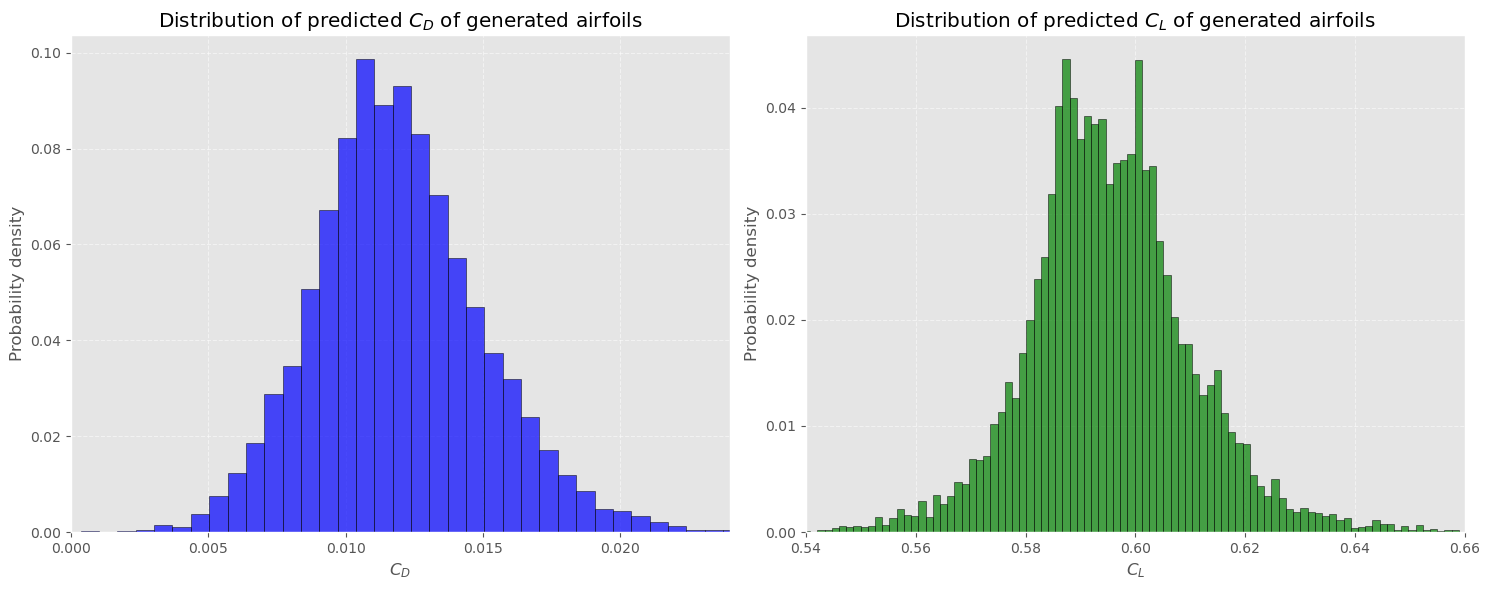

In [14]:
def get_hist(samples, test_cond, bins, cd_min, cd_max, cl_min, cl_max, tick_num, save_name):
    tmp_pred = get_surrogate_pred(samples, repeat(torch.tensor(test_cond[2:], dtype=torch.float32, device=device), 'w -> h w', h=samples.shape[0]))

    # Dummy inverse transformation, replace with your actual scaler
    tmp_cd = tmp_pred[:, 0].detach().cpu().numpy()  
    tmp_cl = tmp_pred[:, 1].detach().cpu().numpy()

    # Set the style
    plt.style.use('ggplot')

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot for Cd
    weights_cd = np.ones_like(tmp_cd) / len(tmp_cd)
    axes[0].hist(tmp_cd, bins=bins, color='blue', alpha=0.7, edgecolor='black', weights=weights_cd)
    axes[0].set_xlabel('$C_D$')
    axes[0].set_ylabel('Probability density')
    axes[0].set_title('Distribution of predicted $C_D$ of generated airfoils')
    axes[0].set_xlim(cd_min, cd_max)
    #axes[0].set_xticklabels(["{:.3f}".format(i) for i in np.linspace(cd_min, cd_max, num=tick_num)], rotation=45)
    axes[0].grid(True, linestyle='--', alpha=0.5, which='both')

    # Plot for Cl
    weights_cl = np.ones_like(tmp_cl) / len(tmp_cl)
    axes[1].hist(tmp_cl, bins=bins, color='green', alpha=0.7, edgecolor='black', weights=weights_cl)
    axes[1].set_xlabel('$C_L$')
    axes[1].set_ylabel('Probability density')
    axes[1].set_title('Distribution of predicted $C_L$ of generated airfoils')
    axes[1].set_xlim(cl_min, cl_max)
    #axes[1].set_xticklabels(["{:.2f}".format(i) for i in np.linspace(cl_min, cl_max, num=tick_num)], rotation=45)
    axes[1].grid(True, linestyle='--', alpha=0.5, which='both')

    # Adjust layout and save
    plt.tight_layout()
    #plt.savefig('figs/' + save_name + '.eps', dpi=600)
    plt.show()

get_hist(samples, test_cond, 100, 0., 0.024, 0.54, 0.66, 13, 'cd_hist')

In [15]:
cd_tol =0.007546535001334254/2
cl_tol =0.06477188984775005/2
MIN_CD_IN_DATA = 0.002649999922141433 
max_iter = 100
lr = 5E-4
stop_frac = 0.75
test_cond = np.array([0.01393344, 0.59405982, 0.47368421, 0.51704545])
list_of_best_designs_w_cdpred = []
best_cd = np.inf
worth_cd = np.inf

def get_samples(model, vp, test_cond, sample_size=10000, method='EDM', deterministic=True):
    sample_size = sample_size
    if method == 'CFG':
        pf_sampler = ProbabilityFlowODE(1000, 1e-5)
        # Get test_cond for each index in indices
        samples, _ = pf_sampler(model, vp, (sample_size, 6), device, c=repeat(torch.tensor(test_cond, dtype=torch.float32, device=device), 'w -> h w', h=sample_size), return_intermediates=False)
    elif method == 'EDM':
        rnd = StackedRandomGenerator(device, range(sample_size))
        latents = rnd.randn([sample_size, model.in_dim], device=device)
        with torch.no_grad():
            samples, _ = edm_sampler(model, latents=latents, class_labels=repeat(torch.tensor(test_cond, dtype=torch.float32, device=device), 'w -> h w', h=sample_size), randn_like=rnd.randn_like, deterministic=deterministic) 
        samples = samples.float()
    else:
        raise NotImplementedError
    return samples

def get_design(samples, test_cond, target_cd, target_cl, cd_tol, cl_tol):
    num_samples = samples.shape[0]
    tmp_pred = get_surrogate_pred(samples, repeat(torch.tensor(test_cond[2:], dtype=torch.float32, device=device), 'w -> h w', h=sample_size))
    gen_cd = minmax_scaler['Cd'].inverse_transform(tmp_pred[:,0].detach().cpu().numpy().reshape(-1,1)).flatten() 
    gen_cl = minmax_scaler['Cl'].inverse_transform(tmp_pred[:,1].detach().cpu().numpy().reshape(-1,1)).flatten()
    cd_percentage = np.sum(np.abs(gen_cd - target_cd) <= cd_tol)/num_samples*100
    cl_percentage = np.sum(np.abs(gen_cl - target_cl) <= cl_tol)/num_samples*100
    cd_limit = min(cd_tol, min(np.mean(gen_cd)-np.percentile(gen_cd,25), np.percentile(gen_cd,75)-np.mean(gen_cd)))
    cl_limit = min(cl_tol, min(np.mean(gen_cl)-np.percentile(gen_cl,25), np.percentile(gen_cl,75)-np.mean(gen_cl)))
    #cd_limit = cd_tol
    #cl_limit = cl_tol
    idx_within_range = np.where(np.abs(gen_cd - target_cd) <= cd_limit)[0]
    idx_outof_range = np.where(np.abs(gen_cd - target_cd) > cd_limit)[0]
    idx_cl_within_range = np.where(np.abs(gen_cl - target_cl) <= cl_limit)[0]
    idx_within_range = np.intersect1d(idx_within_range, idx_cl_within_range)
    idx_outof_cd_within_cl_range = np.intersect1d(idx_outof_range, idx_cl_within_range)
    idx_min_cd_in_range = idx_within_range[np.argmin(gen_cd[idx_within_range])]
    idx_min_cd_outof_range = idx_outof_cd_within_cl_range[np.argmin(gen_cd[idx_outof_cd_within_cl_range])]

    return idx_min_cd_in_range, idx_min_cd_outof_range, gen_cd, gen_cl, cd_percentage, cl_percentage

for num_iter in range(max_iter):
    target_cd = minmax_scaler['Cd'].inverse_transform(test_cond[0].reshape(-1,1)).flatten()[0]
    target_cl = minmax_scaler['Cl'].inverse_transform(test_cond[1].reshape(-1,1)).flatten()[0]
    samples = get_samples(model, vp, test_cond, sample_size=10000)
    idx_min_cd_in_range, idx_min_cd_outof_range, sample_cd, sample_cl, cd_percentage, cl_percentage = get_design(samples, test_cond, target_cd, target_cl, cd_tol, cl_tol)
    list_of_best_designs_w_cdpred.append((samples[idx_min_cd_in_range], target_cd))
    mean_sample_cd = np.mean(sample_cd)
    mean_sample_cl = np.mean(sample_cl)
    cd_div = np.abs(mean_sample_cd- target_cd)
    cl_div = np.abs(mean_sample_cl- target_cl)
    cl_skew = stats.skew(sample_cl)
    cd_skew = stats.skew(sample_cd)
    if best_cd > sample_cd[idx_min_cd_in_range]:
        best_cd = sample_cd[idx_min_cd_in_range]
        best_design = samples[idx_min_cd_in_range]
        best_cl = sample_cl[idx_min_cd_in_range]
        print('updated best_cd: ', best_cd, 'best_cl: ', best_cl, 'iter: ', num_iter)
    if worth_cd > sample_cd[idx_min_cd_outof_range]:
        worth_cd = sample_cd[idx_min_cd_outof_range]
        worth_explore = samples[idx_min_cd_outof_range]
        worth_cl = sample_cl[idx_min_cd_outof_range]
    if num_iter == 0:
        ini_cd_percentage = cd_percentage
        ini_cl_percentage = cl_percentage
        ini_cd_div = cd_div
    #print('iter: ', num_iter, ', Cd condition: ', target_cd, ' Div between target & sample mean:', cd_div, ', Cd sample% within range', cd_percentage, ', Cl sample% within range', cl_percentage, ', min cd in range: ', sample_cd[idx_min_cd_in_range], 'min cd out of range: ', sample_cd[idx_min_cd_outof_range])
    print('iter: {}, Cl skew: {:.4f}, Cd skew: {:.4f}, Cd condition: {:.6f}, Cd Diff between mean&target: {:.6f}, Cl Diff between mean&target: {:.6f}, Cd sample% within range {:.6f}, Cl sample% within range {:.6f}, min cd in range: {:.6f}, min cd out of range: {:.6f}'.format(num_iter, cl_skew, cd_skew, target_cd, cd_div, cl_div, cd_percentage, cl_percentage, sample_cd[idx_min_cd_in_range], sample_cd[idx_min_cd_outof_range]))
    if cd_percentage <= stop_frac*ini_cd_percentage or cl_percentage <= stop_frac*ini_cl_percentage:
        print('stopped by percentage')
        break
    if num_iter !=0 and (cd_div+cd_tol>=target_cd or cl_div+cl_tol>=target_cl):
        print('stopped by deviation')
        break
    test_cond[0] -= lr

updated best_cd:  0.00977743 best_cl:  0.5386163 iter:  0
iter: 0, Cl skew: 0.3134, Cd skew: 0.3072, Cd condition: 0.010860, Cd Diff between mean&target: 0.001177, Cl Diff between mean&target: 0.006327, Cd sample% within range 92.120000, Cl sample% within range 38.890000, min cd in range: 0.009777, min cd out of range: -0.003946
updated best_cd:  0.009554881 best_cl:  0.5674334 iter:  1
iter: 1, Cl skew: 0.2817, Cd skew: 0.6943, Cd condition: 0.010565, Cd Diff between mean&target: 0.000971, Cl Diff between mean&target: 0.005238, Cd sample% within range 93.620000, Cl sample% within range 39.850000, min cd in range: 0.009555, min cd out of range: 0.004495
updated best_cd:  0.0092779575 best_cl:  0.56620634 iter:  2
iter: 2, Cl skew: 0.3488, Cd skew: 0.5853, Cd condition: 0.010271, Cd Diff between mean&target: 0.000784, Cl Diff between mean&target: 0.005244, Cd sample% within range 95.190000, Cl sample% within range 41.230000, min cd in range: 0.009278, min cd out of range: 0.001275
updat

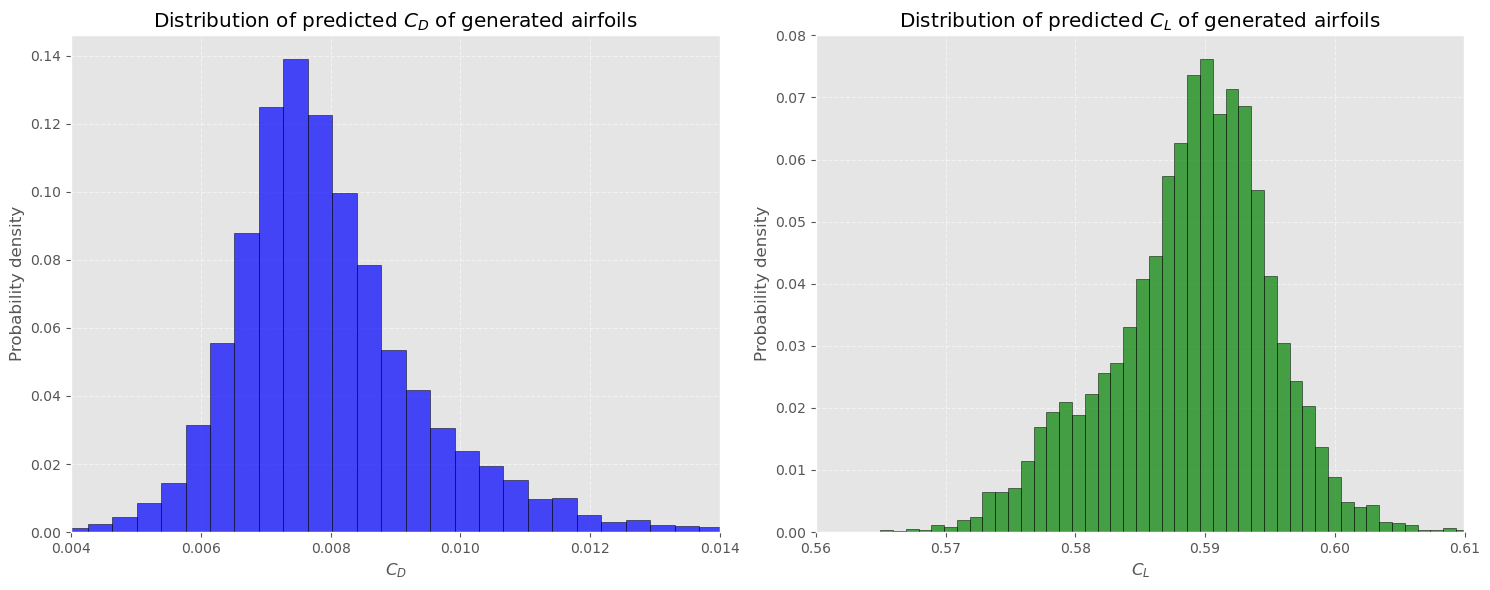

In [16]:
get_hist(samples, test_cond, 100, 0.004, 0.014, 0.56, 0.61, 13, 'cd_hist_final_iter')

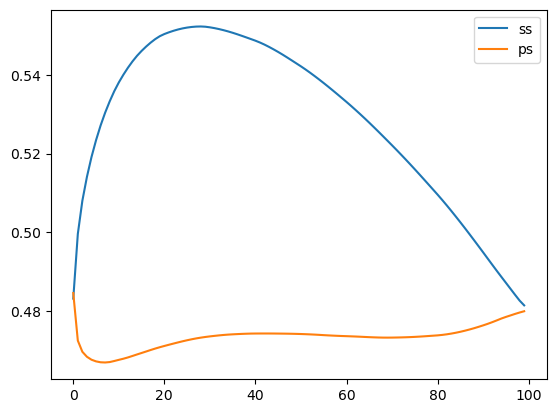

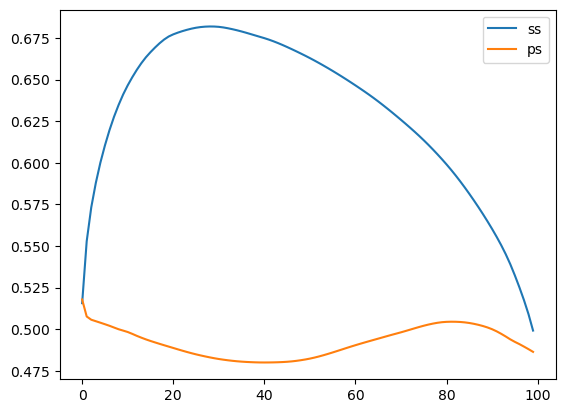

In [17]:
plot_airfoil(best_design.detach().cpu().numpy(), 'best_design')
plot_airfoil(worth_explore.detach().cpu().numpy(), 'worth_explore')

In [18]:
print('Best Cd: ', best_cd, 'Worth Cd: ', worth_cd)
print('Best Cl: ', best_cl, 'Worth Cl: ', worth_cl)

Best Cd:  0.00492798 Worth Cd:  -0.007866422
Best Cl:  0.56300265 Worth Cl:  0.5464168


In [19]:
orig_space_y_coords = pca.inverse_transform(unique_y_coords)
best_design_orig_space = pca.inverse_transform(best_design.detach().cpu().numpy()).reshape(1,-1)
worth_explore_orig_space = pca.inverse_transform(worth_explore.detach().cpu().numpy()).reshape(1,-1)
print(orig_space_y_coords.shape, best_design_orig_space.shape, worth_explore_orig_space.shape)

(825, 200) (1, 200) (1, 200)


In [20]:
tmp = pca.inverse_transform(best_design.detach().cpu().numpy()).reshape(2,100)
#np.save('generated_airfoils/best_design.npy', tmp)
tmp = pca.inverse_transform(worth_explore.detach().cpu().numpy()).reshape(2,100)
#np.save('generatire_airfoils/worth_explore.npy', tmp)

In [21]:
class surrogate_opt_wrapper:
    def __init__(self, test_cond):
        self.test_cond = test_cond
    def __call__(self, x):
        pred_cd = get_surrogate_pred(torch.tensor(x, dtype=torch.float32, device=device).reshape(1,-1), torch.tensor(self.test_cond[2:], dtype=torch.float32, device=device).reshape(1,-1))
        return pred_cd[0].cpu().detach().numpy().flatten()[0]
    def _full_return(self, x):
        pred_cd = get_surrogate_pred(torch.tensor(x, dtype=torch.float32, device=device).reshape(1,-1), torch.tensor(self.test_cond[2:], dtype=torch.float32, device=device).reshape(1,-1))
        return pred_cd[0].cpu().detach().numpy().flatten()[0], pred_cd[0].cpu().detach().numpy().flatten()[1]

surrogate_opt = surrogate_opt_wrapper(test_cond)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.005388040095567703
        x: [-4.375e-02 -2.803e-01 -8.385e-02  1.162e-01 -5.918e-03
             2.980e-02]
      nit: 5
      jac: [ 1.250e+00  1.000e+00  1.000e+00  1.250e+00  1.250e+00
             0.000e+00]
 hess_inv: [[ 1.631e+00 -2.524e+00 ... -6.020e-01 -5.504e-01]
            [-2.524e+00  4.087e+00 ...  9.757e-01  8.097e-01]
            ...
            [-6.020e-01  9.757e-01 ...  2.420e-01  1.822e-01]
            [-5.504e-01  8.097e-01 ...  1.822e-01  2.152e-01]]
     nfev: 376
     njev: 52
Cl:  0.5319748


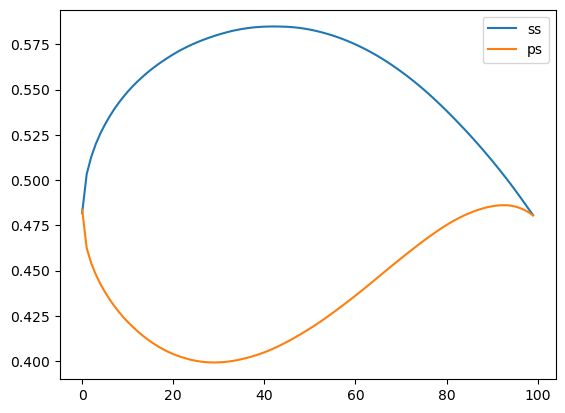

In [22]:
from scipy.optimize import minimize

def callback(x, target_cl=minmax_scaler['Cl'].inverse_transform(test_cond[1].reshape(-1,1)).flatten()[0], cl_tol=0.06477188984775005/2):
    current_cd, current_cl = surrogate_opt._full_return(x)
    if current_cd < 0:
        raise StopIteration
    #if np.abs(current_cl - target_cl) >= cl_tol:
    #    raise StopIteration

res = minimize(surrogate_opt, baseline_red_y_coord, method='BFGS', callback=callback)
print(res)
tmp_pred = surrogate_model(torch.cat((torch.tensor(res.x, dtype=torch.float32, device=device).reshape(1,-1), torch.tensor(test_cond[2:], dtype=torch.float32, device=device).reshape(1,-1)), dim=1))
print('Cl: ', minmax_scaler['Cl'].inverse_transform(tmp_pred[0,1].detach().cpu().numpy().reshape(-1,1)).flatten()[0])
plot_airfoil(res.x, 'scipy_BFGS')
tmp = pca.inverse_transform(res.x).reshape(2,100)
scipy_BFGS = tmp.copy().reshape(1,-1)
#np.save('generated_airfoils/scipy_BFGS.npy', tmp)

       message: `callback` raised `StopIteration`.
       success: False
        status: 99
           fun: -0.00022557005286216736
             x: [-4.569e-02 -1.303e-01 -9.045e-02  9.566e-02 -6.837e-03
                  4.735e-02]
           nit: 92
          nfev: 140
 final_simplex: (array([[-4.569e-02, -1.303e-01, ..., -6.837e-03,
                         4.735e-02],
                       [-4.166e-02, -1.482e-01, ..., -6.006e-03,
                         4.848e-02],
                       ...,
                       [-4.182e-02, -1.368e-01, ..., -6.424e-03,
                         4.837e-02],
                       [-4.230e-02, -1.209e-01, ..., -6.635e-03,
                         4.730e-02]], dtype=float32), array([-2.256e-04,  2.897e-05,  5.756e-05,  6.698e-05,
                        8.839e-05,  1.153e-04,  1.183e-04]))
Cl:  0.71015143


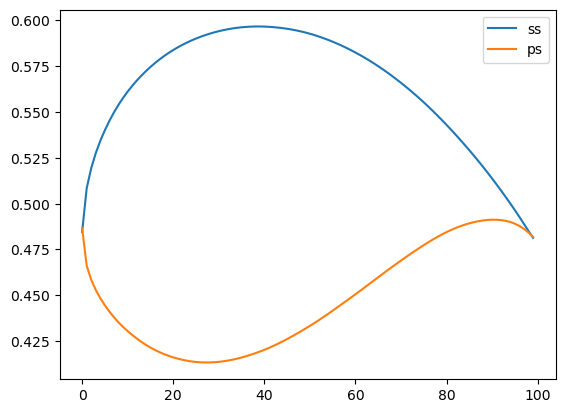

In [23]:
res = minimize(surrogate_opt, baseline_red_y_coord, method='Nelder-Mead', options={'maxiter': 1000}, callback=callback)
print(res)
tmp_pred = surrogate_model(torch.cat((torch.tensor(res.x, dtype=torch.float32, device=device).reshape(1,-1), torch.tensor(test_cond[2:], dtype=torch.float32, device=device).reshape(1,-1)), dim=1))
print('Cl: ', minmax_scaler['Cl'].inverse_transform(tmp_pred[0,1].detach().cpu().numpy().reshape(-1,1)).flatten()[0])
plot_airfoil(res.x, 'scipy_NM')
tmp = pca.inverse_transform(res.x).reshape(2,100)
scipy_NM = tmp.copy().reshape(1,-1)
#np.save('generated_airfoils/scipy_NM.npy', tmp)

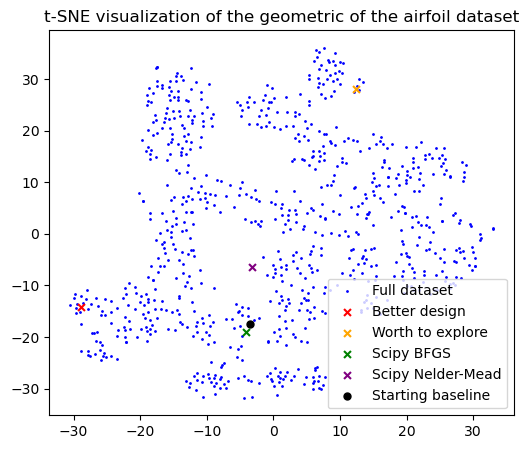

In [24]:
from sklearn.manifold import TSNE

# Combine orig_space_y_coords and best_design_orig_space
combined = np.vstack((orig_space_y_coords, baseline_y_coord.reshape(1,-1), scipy_BFGS, scipy_NM, best_design_orig_space, worth_explore_orig_space))

# Perform t-SNE on the combined data
tsne = TSNE(n_components=2, random_state=0)
combined_2d = tsne.fit_transform(combined)

# Separate the transformed coordinates
orig_space_y_coords_2d = combined_2d[:-5]
baseline_orig_space_2d = combined_2d[-5]
scipy_BFGS_orig_space_2d = combined_2d[-4]
scipy_NM_orig_space_2d = combined_2d[-3]
best_design_orig_space_2d = combined_2d[-2]
worth_explore_orig_space_2d = combined_2d[-1]
# Plot the results
plt.figure(figsize=(6, 5))
plt.scatter(orig_space_y_coords_2d[:, 0], orig_space_y_coords_2d[:, 1], c='blue', label='Full dataset', s=1)
plt.scatter(best_design_orig_space_2d[0], best_design_orig_space_2d[1], c='red', label='Better design', s=25, marker='x')
plt.scatter(worth_explore_orig_space_2d[0], worth_explore_orig_space_2d[1], c='orange', label='Worth to explore', s=25, marker='x')
plt.scatter(scipy_BFGS_orig_space_2d[0], scipy_BFGS_orig_space_2d[1], c='green', label='Scipy BFGS', s=25, marker='x')
plt.scatter(scipy_NM_orig_space_2d[0], scipy_NM_orig_space_2d[1], c='purple', label='Scipy Nelder-Mead', s=25, marker='x')
plt.scatter(baseline_orig_space_2d[0], baseline_orig_space_2d[1], c='black', label='Starting baseline', s=25, marker='o')
plt.legend()
plt.title('t-SNE visualization of the geometric of the airfoil dataset')
#plt.savefig('figs/tsne.png', dpi=600)
plt.show()